# Retinal CNV Segmentasyonu Projesi

## Problem Tanımı
Retinal Choroidal Neovascularization (CNV), retina üzerinde anormal damar büyümeleriyle karakterize edilen bir hastalıktır. CNV, görme kaybına yol açabilen bir durumdur ve erken teşhisi önemlidir. Bu projede, retinal görüntüler üzerinde CNV segmentasyonu yapmak hedeflenmektedir. CNV segmentasyonu, retina hastalıklarının daha doğru ve hızlı teşhis edilmesine yardımcı olacaktır.

## Amaç
Bu projenin amacı, retinal görüntülerdeki CNV bölgelerinin doğru bir şekilde segmentasyonunu yaparak, otomatik tıbbi teşhis sistemlerine katkıda bulunmaktır. Bu, sağlık profesyonellerine daha verimli bir şekilde teşhis koyma imkanı sunacaktır.

## Personele Katkısı
Bu proje, sağlık profesyonellerinin CNV'yi daha hızlı bir şekilde teşhis etmelerine yardımcı olacak bir araç geliştirmeyi amaçlamaktadır. Ayrıca, tıbbi görüntü analizi alanında yeni algoritmaların geliştirilmesine katkı sağlayacaktır.

## Veri Seti Tanımı
Veri seti, retinal görüntülerden oluşan bir koleksiyondan alınmıştır. Bu görüntüler, CNV segmentasyonu yapmak için etiketlenmiştir ve üç ana bölüme ayrılmaktadır:
- **Test Görüntüleri**: `/Users/koray/Desktop/24/test/` 
- **Train Görüntüleri**: `/Users/koray/Desktop/24/train/` 
- **Validation Görüntüleri**: `/Users/koray/Desktop/24/val/`
- Bütün görüntülerin boyutları 512x512'dir.

![Label İlk Görüntü](../Desktop/24/label/label1.png)
![Train İlk Görüntü](../Desktop/24/train/cnvt1.jpeg)



### Kütüphanelerin İmport Edilmesi

In [47]:
import os
import glob
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import requests
import torch.nn.functional as F

### Klasördeki Görüntü ve Maskelerin Değişkene Atanması

In [49]:
# Test ve Eğitim veri dosyalarını yükleme
x_train = sorted(glob.glob("/Users/koray/Desktop/24/train/*"))
y_train = sorted(glob.glob("/Users/koray/Desktop/24/label/*"))
print(len(x_train), len(y_train))

40 40


### İlk 3 görüntünün ekranda gösterilmesi

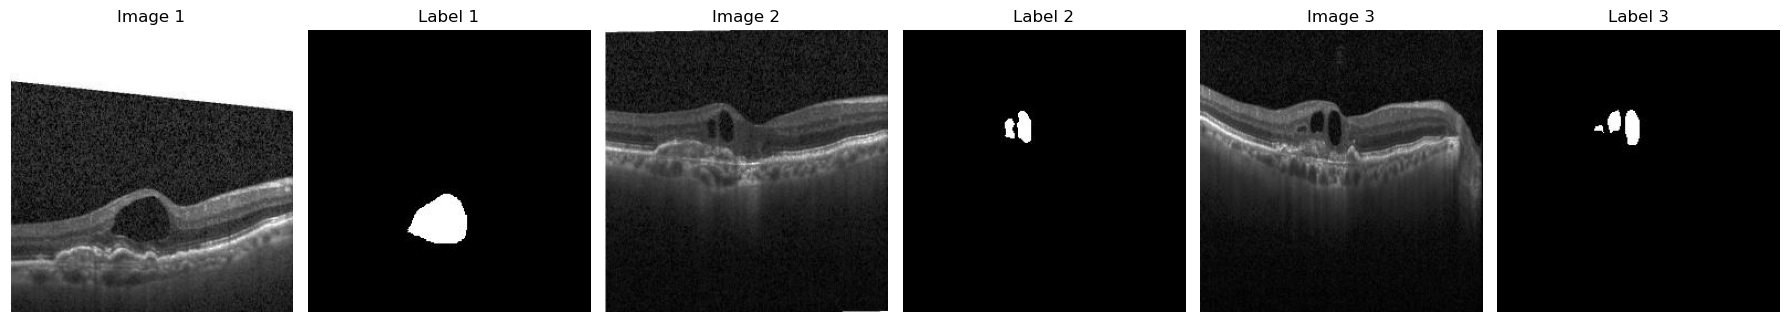

In [51]:
# İlk kısımda 3 örnek veri gösterme
def display_samples():
    fig, axs = plt.subplots(1, 6, figsize=(18, 5))  # Yatay bir satırda 6 hücre içeren bir ızgara oluştur
    for i in range(3):
        img = cv2.imread(x_train[i])
        label = cv2.imread(y_train[i], cv2.IMREAD_GRAYSCALE)

        # Görüntüyü göster
        axs[i * 2].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axs[i * 2].set_title(f"Image {i+1}")
        axs[i * 2].axis("off")

        # Etiketi göster
        axs[i * 2 + 1].imshow(label, cmap="gray")
        axs[i * 2 + 1].set_title(f"Label {i+1}")
        axs[i * 2 + 1].axis("off")

    plt.tight_layout()
    plt.show()
# İlk 3 görüntü ve etiketi göster
display_samples()

### ScaleNormUNet Modeli

In [53]:
class ScaleNormUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(ScaleNormUNet, self).__init__()
        def CBR(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        # Encoder katmanları
        self.enc1 = CBR(in_channels, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.enc4 = CBR(256, 512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = CBR(512, 1024)

        # Decoder katmanları
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = CBR(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = CBR(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = CBR(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = CBR(128, 64)

        # Çıkış katmanı
        self.conv_last = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        bottleneck = self.bottleneck(self.pool(enc4))

        # Decoder
        upconv4 = self.upconv4(bottleneck)
        if upconv4.size(2) != enc4.size(2) or upconv4.size(3) != enc4.size(3):
            diffY = enc4.size(2) - upconv4.size(2)
            diffX = enc4.size(3) - upconv4.size(3)
            upconv4 = F.pad(upconv4, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        dec4 = self.dec4(torch.cat([upconv4, enc4], dim=1))

        upconv3 = self.upconv3(dec4)
        if upconv3.size(2) != enc3.size(2) or upconv3.size(3) != enc3.size(3):
            diffY = enc3.size(2) - upconv3.size(2)
            diffX = enc3.size(3) - upconv3.size(3)
            upconv3 = F.pad(upconv3, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        dec3 = self.dec3(torch.cat([upconv3, enc3], dim=1))

        upconv2 = self.upconv2(dec3)
        if upconv2.size(2) != enc2.size(2) or upconv2.size(3) != enc2.size(3):
            diffY = enc2.size(2) - upconv2.size(2)
            diffX = enc2.size(3) - upconv2.size(3)
            upconv2 = F.pad(upconv2, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        dec2 = self.dec2(torch.cat([upconv2, enc2], dim=1))

        upconv1 = self.upconv1(dec2)
        if upconv1.size(2) != enc1.size(2) or upconv1.size(3) != enc1.size(3):
            diffY = enc1.size(2) - upconv1.size(2)
            diffX = enc1.size(3) - upconv1.size(3)
            upconv1 = F.pad(upconv1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        dec1 = self.dec1(torch.cat([upconv1, enc1], dim=1))

        return torch.sigmoid(self.conv_last(dec1))

### Görüntü ve maske verisini yüklemek için Dataset sınıfı

In [55]:
class SegmentationDataset(Dataset):
    def __init__(self, images, masks, transform=None, target_size=None):
        self.images = images
        self.masks = masks
        self.transform = transform
        self.target_size = target_size  

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = cv2.imread(self.images[idx]) / 255.0
        mask = cv2.imread(self.masks[idx], cv2.IMREAD_GRAYSCALE) / 255.0

        if self.target_size:
            image = cv2.resize(image, self.target_size, interpolation=cv2.INTER_AREA)
            mask = cv2.resize(mask, self.target_size, interpolation=cv2.INTER_NEAREST)

        mask = np.expand_dims(mask, axis=0)
        if self.transform:
            image = self.transform(image)
            mask = torch.tensor(mask, dtype=torch.float32)

        return image, mask

In [57]:
def calculate_mean_std(loader):
    mean = 0.0
    std = 0.0
    total_images_count = 0

    for images, _ in loader:
        images = images / 255.0  
        mean += images.mean([0, 2, 3])  
        std += images.std([0, 2, 3])    
        total_images_count += 1

    mean /= total_images_count
    std /= total_images_count
    return mean, std

### Eğitim ve test setlerinin oluşturulması, Trasnfor ile veri yükleme, Ortalama standart sapma hesaplanması, Normalize işlemi için hesaplanan değerlerin kullanılması, Dataloaders oluşturma, Accuracy hesaplama, modeli ve optimizasyonu tanımlama

In [59]:
x_train = sorted(glob.glob("/Users/koray/Desktop/24/train/*"))
y_train = sorted(glob.glob("/Users/koray/Desktop/24/label/*"))

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train)

simple_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset_simple = SegmentationDataset(x_train, y_train, transform=simple_transform)
train_loader_simple = DataLoader(train_dataset_simple, batch_size=1, shuffle=False)
mean, std = calculate_mean_std(train_loader_simple)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist()) 
])

target_size = (128, 128) 
train_dataset = SegmentationDataset(x_train, y_train, transform=transform, target_size=target_size)
test_dataset = SegmentationDataset(x_test, y_test, transform=transform, target_size=target_size)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1)



def calculate_accuracy(pred, mask, threshold=0.5):
    pred = (pred > threshold).float()
    correct = (pred == mask).float().sum()
    return correct / mask.numel()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ScaleNormUNet().to(device)  # ScaleNormUNet modelini kullanma
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss()


In [61]:
num_epochs = 10
model.train()

loss_values = []
accuracy_values = []

for epoch in range(num_epochs):
    total_loss = 0.0
    total_accuracy = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device, dtype=torch.float32), masks.to(device, dtype=torch.float32)
        outputs = model(images)
        loss = criterion(outputs, masks)

        accuracy = calculate_accuracy(outputs, masks)
        total_accuracy += accuracy.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    avg_accuracy = total_accuracy / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss}, Accuracy: {avg_accuracy}")

    loss_values.append(avg_loss)
    accuracy_values.append(avg_accuracy)

Epoch 1/10, Loss: 0.5678984175125757, Accuracy: 0.8450439453125
Epoch 2/10, Loss: 0.4403654356797536, Accuracy: 0.9584004720052083
Epoch 3/10, Loss: 0.38790982166926063, Accuracy: 0.9767171223958333
Epoch 4/10, Loss: 0.3503354956706365, Accuracy: 0.979766845703125
Epoch 5/10, Loss: 0.32545305987199147, Accuracy: 0.9805033365885417
Epoch 6/10, Loss: 0.3036340564489365, Accuracy: 0.98067626953125
Epoch 7/10, Loss: 0.285898553331693, Accuracy: 0.9814208984375
Epoch 8/10, Loss: 0.2681612133979797, Accuracy: 0.984100341796875
Epoch 9/10, Loss: 0.2511107857028643, Accuracy: 0.9869038899739583
Epoch 10/10, Loss: 0.23538132657607397, Accuracy: 0.9870707194010416


### Modeli Kaydet

In [63]:
torch.save(model.state_dict(), 'model.pth')

### Görselleştirme ve grafik

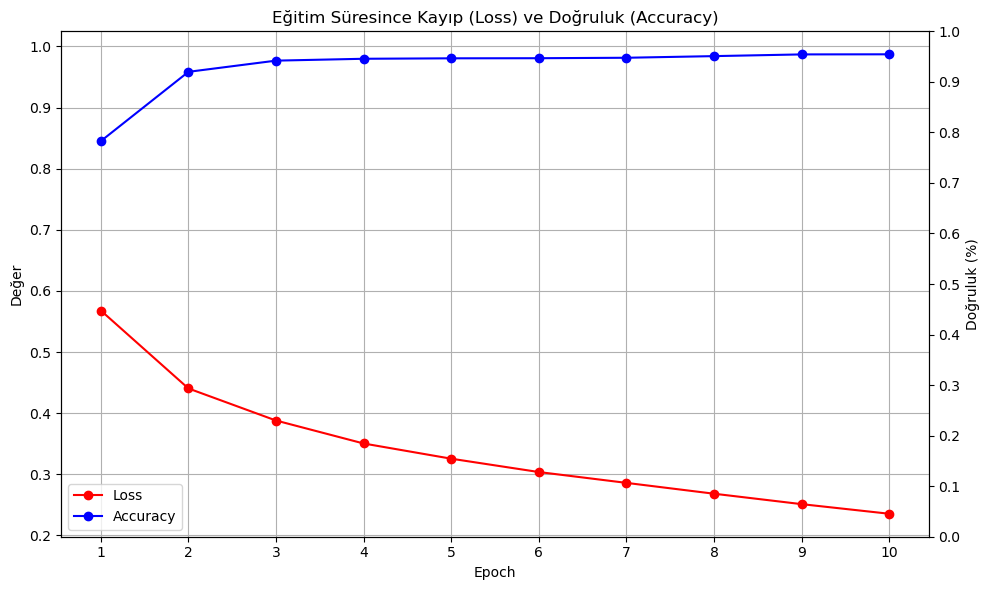

In [65]:
plt.figure(figsize=(10, 6))

plt.plot(range(1, num_epochs + 1), loss_values, marker='o', color='red', label='Loss')
plt.plot(range(1, num_epochs + 1), accuracy_values, marker='o', color='blue', label='Accuracy')
plt.title('Eğitim Süresince Kayıp (Loss) ve Doğruluk (Accuracy)')
plt.xlabel('Epoch')
plt.ylabel('Değer')
plt.xticks(range(1, num_epochs + 1))
plt.legend()
plt.grid()

ax2 = plt.gca().twinx()  
ax2.set_ylabel('Doğruluk (%)')
ax2.set_ylim(0, 1)  
ax2.set_yticks([i / 10 for i in range(11)])

plt.tight_layout()
plt.show()

### En iyi ve en kötü tahmin

/var/folders/v0/ksj7h62x33q6rmnxkxpzsqfr0000gn/T/ipykernel_1338/1545445037.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = img * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)


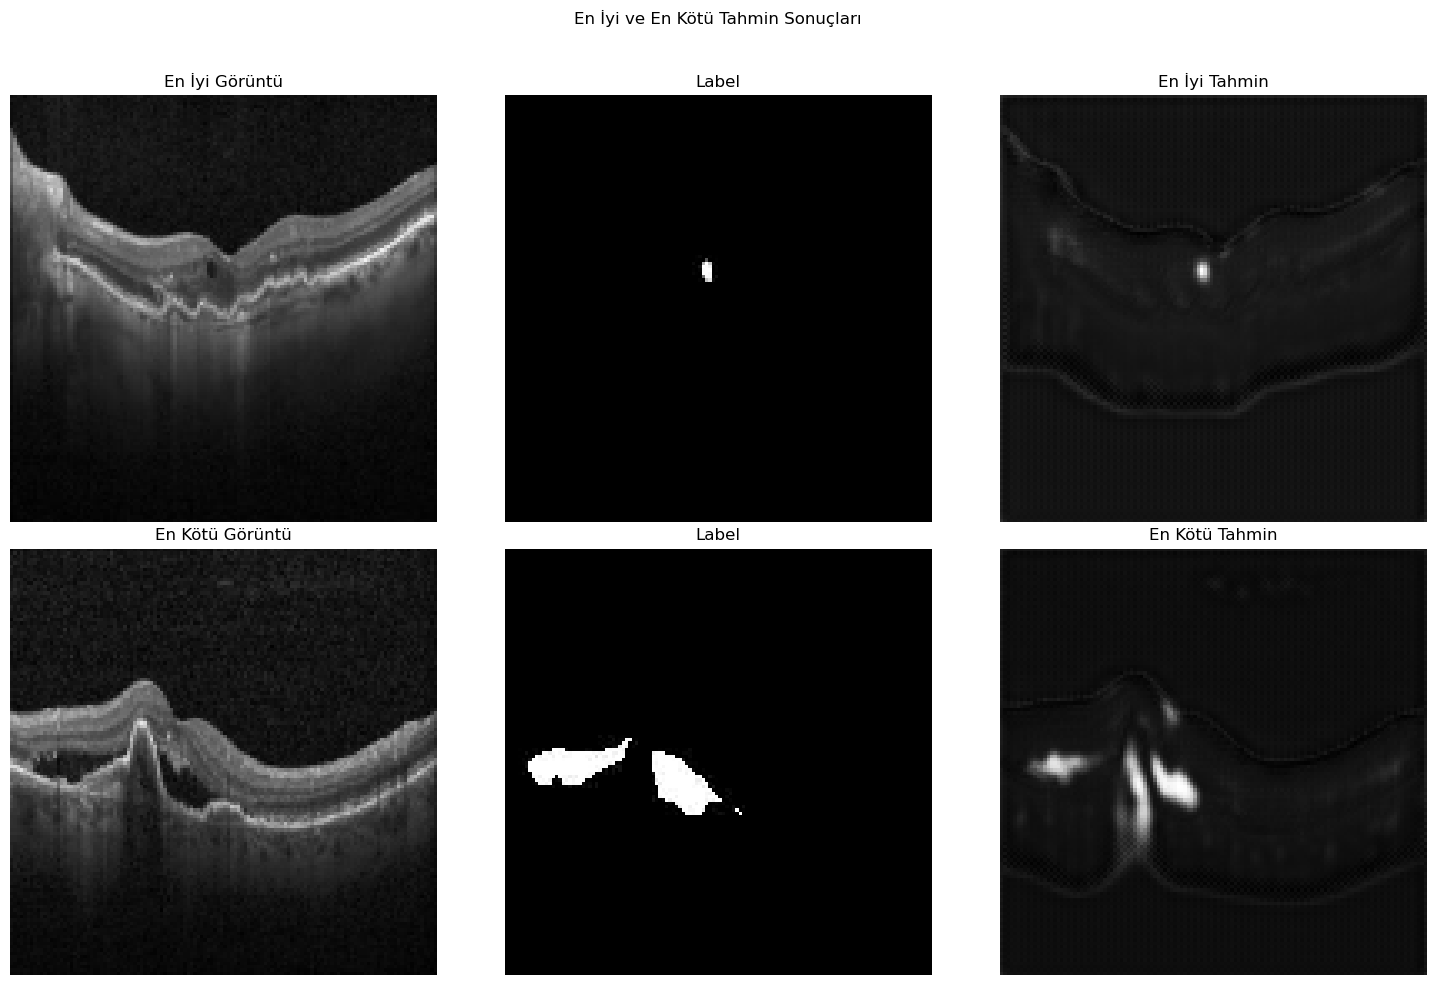

In [45]:
def find_best_and_worst_predictions(model, test_loader, num_best=1, num_worst=1):
    model.eval() 
    best_predictions = []
    worst_predictions = []

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device, dtype=torch.float32), masks.to(device, dtype=torch.float32)
            outputs = model(images)
            accuracy = calculate_accuracy(outputs, masks)

            
            best_predictions.append((images.cpu(), masks.cpu(), outputs.cpu(), accuracy))
            worst_predictions.append((images.cpu(), masks.cpu(), outputs.cpu(), accuracy))

            
            best_predictions = sorted(best_predictions, key=lambda x: x[3], reverse=True)[:num_best]
            worst_predictions = sorted(worst_predictions, key=lambda x: x[3])[:num_worst]

   
    fig, axs = plt.subplots(num_best + num_worst, 3, figsize=(15, 5 * (num_best + num_worst)))
    fig.suptitle("En İyi ve En Kötü Tahmin Sonuçları")


    def denormalize(img):
        img = img * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
        return img.clip(0, 1)

    
    for i, (img, label, pred, acc) in enumerate(best_predictions):
        img = denormalize(img[0])  
        axs[i, 0].imshow(img.numpy().transpose(1, 2, 0)) 
        axs[i, 0].set_title("En İyi Görüntü")
        axs[i, 0].axis("off")

        axs[i, 1].imshow(label[0, 0].numpy(), cmap="gray")  
        axs[i, 1].axis("off")

        axs[i, 2].imshow(pred[0, 0].numpy(), cmap="gray")  
        axs[i, 2].set_title("En İyi Tahmin")
        axs[i, 2].axis("off")

    
    for i, (img, label, pred, acc) in enumerate(worst_predictions):
        img = denormalize(img[0])  
        axs[i + num_best, 0].imshow(img.numpy().transpose(1, 2, 0))  
        axs[i + num_best, 0].set_title("En Kötü Görüntü")
        axs[i + num_best, 0].axis("off")

        axs[i + num_best, 1].imshow(label[0, 0].numpy(), cmap="gray")  
        axs[i + num_best, 1].set_title("Label")
        axs[i + num_best, 1].axis("off")

        axs[i + num_best, 2].imshow(pred[0, 0].numpy(), cmap="gray")  
        axs[i + num_best, 2].set_title("En Kötü Tahmin")
        axs[i + num_best, 2].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

find_best_and_worst_predictions(model, test_loader)